In [ ]:
import torch
import torch.nn as nn 
from torch.autograd import Variable 
import torch.nn.functional as F 
import torch.utils.data as Data
import torch.optim as optim

import numpy as np
import pandas as pd 

import matplotlib
import matplotlib.pyplot as plt

import sys
from scipy.stats import chisquare
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split


class RBFLayer(nn.Module):
    def __init__(self, inFeatures, outFeatures, centers, useAvgDist):
        super(RBFLayer, self).__init__()
        self.inFeatures = inFeatures
        self.outFeatures = outFeatures
        self.centers = torch.from_numpy(centers).float()
        # calcualte distance between any two cluster centers in centers variable
        clusterDistances = [np.linalg.norm(c1 - c2) for c1 in centers for c2 in centers] 
        dMax = max(clusterDistances)
        dAvg = sum(clusterDistances)  /  len(clusterDistances)
        # define tensor of sigmas of dimension 1 x len(centers) 
        if useAvgDist == True:
             self.sigma = torch.full( (1, len(self.centers)), (2*dAvg) )
        else:
            self.sigma = torch.full( (1, len(self.centers)), (np.sqrt(dMax) / len(self.centers)) )
        

    def forward(self, input):
        # Input has shape batchSize x inFeature
        batchSize = input.size(0)

        mu = self.centers.view(len(self.centers), -1).repeat(batchSize, 1, 1)
        X = input.view(batchSize, -1).unsqueeze(1).repeat(1, len(self.centers), 1)        

        # Gaussian RBF
        #Phi = torch.exp( -(torch.pow(X-mu, 2).sum(2, keepdim=False) / (2*torch.pow(self.sigma, 2))) )
        # Custom Function
        #Phi = torch.exp(-self.sigma.mul((X-mu).pow(2).sum(2, keepdim=False).sqrt() ) )
        # Multi-Quadric RBF
        Phi = torch.sqrt( self.sigma.pow(2).add(  (X-mu).pow(2).sum(2, keepdim=False) ) )
        #print((1e-9 + Phi.sum(dim=-1).unsqueeze(1)).size())
        #print("Phi", Phi.size())
        #Phi = Phi.divide( (1e-9 + Phi.sum(dim=-1).squeeze(0)) )
        
       # 
        return(Phi)
        
        
class RBFNet(nn.Module):
    def __init__(self, inFeatures, outFeatures, centers, useAvgDist):
        super(RBFNet, self).__init__()
        self.inFeatures = inFeatures
        self.outFeatures = outFeatures
        self.rbf = RBFLayer(inFeatures, len(centers), centers, useAvgDist)
        self.linear = nn.Linear(len(centers), outFeatures)
    
    def forward(self, x):
        x = self.rbf(x)
        #x = torch.tanh(x)
        x = self.linear(x)
        x = torch.tanh(x)
        return(x.squeeze(1))


NUM_SAMPLES = 250
X = np.random.uniform(-np.pi/3, np.pi/3, NUM_SAMPLES)
X = np.sort(X, axis=0)
noise = np.random.uniform(-0.1, 0.1, NUM_SAMPLES)
y = np.sin(2 * np.pi * X)  + noise
# reshape bc its 1D array: https://stackoverflow.com/questions/28416408/scikit-learn-how-to-run-kmeans-on-a-one-dimensional-array 
kmeans = KMeans(n_clusters=8, random_state=0).fit(X.reshape(-1,1))
centers = kmeans.cluster_centers_
#print(centers)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

model = RBFNet(1, 1, centers, False)

print(model)




RBFNet(
  (rbf): RBFLayer()
  (linear): Linear(in_features=8, out_features=1, bias=True)
)


In [ ]:
X_train_tensor = torch.from_numpy(X_train).float()
X_test_tensor = torch.from_numpy(X_test).float()
y_train_tensor = torch.from_numpy(y_train).float()

optimizer = optim.Adam(model.parameters(), lr=0.0080)
loss_fn = nn.MSELoss(reduction='mean')
epochs = 10000
for epoch in range(epochs):
        yhat = model(X_train_tensor)
        #break
        #print("yhat", yhat)
        loss = loss_fn(yhat, y_train_tensor)
        
        # compute gradients
        loss.backward() 
        
        # carry out 1 optimization step with Adam
        optimizer.step()
        
        # reset gradients to zero
        optimizer.zero_grad()


yhat_eval = model(X_test_tensor)    

yhat = yhat.detach().numpy()
yhat_eval = yhat_eval.detach().numpy()




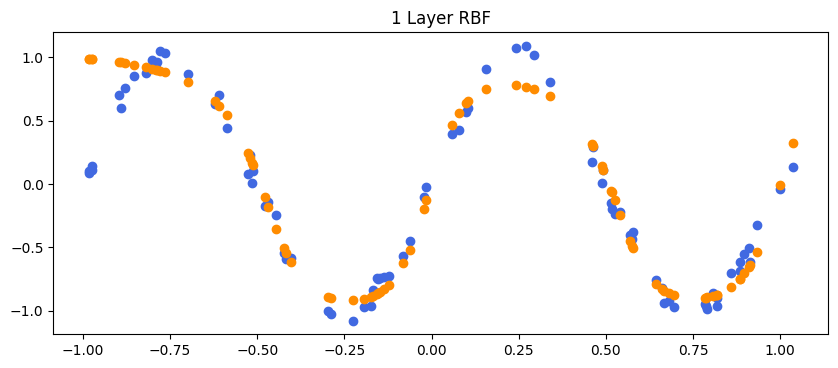

In [ ]:
plt.scatter(X_test, y_test, color='royalblue')
plt.scatter(X_test, yhat_eval, color='darkorange')
plt.title("1 Layer RBF")
plt.rcParams['figure.figsize'] = [10, 4] #set size of plot in output
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
#plt.scatter(X_train, y_train, color='green')
#plt.legend(['Function f(x)', 'RBF output g(x)', 'Training set'])

In [ ]:
class RBFNet2Layer(nn.Module):
    def __init__(self, inFeatures, outFeatures, centers1, centers2, useAvgDist):
        super(RBFNet2Layer, self).__init__()
        self.inFeatures = inFeatures
        self.outFeatures = outFeatures
        self.rbf1 = RBFLayer(inFeatures, len(centers1), centers1, useAvgDist)
        self.linear1 = nn.Linear(len(centers1), len(centers2))
        self.rbf2 = RBFLayer(len(centers2), len(centers2), centers2, useAvgDist)
        self.linear2 = nn.Linear(len(centers2), outFeatures)
    
    def forward(self, x):
        x = self.rbf1(x)
        x = self.linear1(x)
        x = self.rbf2(x)
        x = self.linear2(x)
        return(x.squeeze(1))



# reshape bc its 1D array: https://stackoverflow.com/questions/28416408/scikit-learn-how-to-run-kmeans-on-a-one-dimensional-array 
kmeans1 = KMeans(n_clusters=25, random_state=0).fit(X.reshape(-1,1))
centers1 = kmeans1.cluster_centers_

kmeans2 = KMeans(n_clusters=25, random_state=1).fit(X.reshape(-1,1))
centers2 = kmeans2.cluster_centers_

model = RBFNet2Layer(1, 1, centers1, centers2, True)

print(model)

RBFNet2Layer(
  (rbf1): RBFLayer()
  (linear1): Linear(in_features=25, out_features=25, bias=True)
  (rbf2): RBFLayer()
  (linear2): Linear(in_features=25, out_features=1, bias=True)
)


In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.0005)
loss_fn = nn.MSELoss(reduction='mean')
epochs = 15000
for epoch in range(epochs):
        yhat = model(X_train_tensor)
        #break
        #print("yhat", yhat)
        loss = loss_fn(yhat, y_train_tensor)
        
        # compute gradients
        loss.backward() 
        
        # carry out 1 optimization step with Adam
        optimizer.step()
        
        # reset gradients to zero
        optimizer.zero_grad()


yhat_eval = model(X_test_tensor)

yhat = yhat.detach().numpy()
yhat_eval = yhat_eval.detach().numpy()

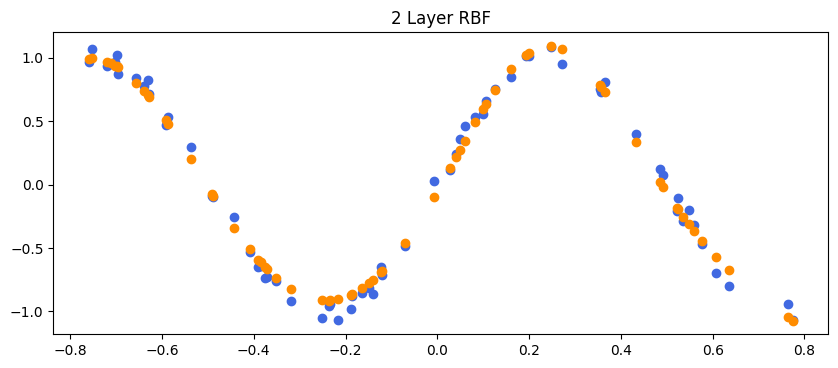

In [ ]:
plt.scatter(X_test, y_test, color='royalblue')
plt.scatter(X_test, yhat_eval, color='darkorange')
plt.title("2 Layer RBF")
plt.rcParams['figure.figsize'] = [10, 4] #set size of plot in output
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
#plt.scatter(X_train, y_train, color='green')
#plt.legend(['Function f(x)', 'RBF output g(x)', 'Training set'])

In [ ]:
class RBFNet3Layer(nn.Module):
    def __init__(self, inFeatures, outFeatures, centers1, centers2, centers3, useAvgDist):
        super(RBFNet3Layer, self).__init__()
        self.inFeatures = inFeatures
        self.outFeatures = outFeatures
        self.rbf1 = RBFLayer(inFeatures, len(centers1), centers1, useAvgDist)
        self.linear1 = nn.Linear(len(centers1), len(centers2))
        self.rbf2 = RBFLayer(len(centers2), len(centers2), centers2, useAvgDist)
        self.linear2 = nn.Linear(len(centers2), len(centers3))
        self.rbf3 = RBFLayer(len(centers3), len(centers3), centers3, useAvgDist)
        self.linear3 = nn.Linear(len(centers3), outFeatures)
    
    def forward(self, x):
        x = self.rbf1(x)
        x = self.linear1(x)
        x = self.rbf2(x)
        x = self.linear2(x)
        x = self.rbf3(x)
        x = self.linear3(x)
        return(x.squeeze(1))

# reshape bc its 1D array: https://stackoverflow.com/questions/28416408/scikit-learn-how-to-run-kmeans-on-a-one-dimensional-array 
kmeans1 = KMeans(n_clusters=25, random_state=0).fit(X.reshape(-1,1))
centers1 = kmeans1.cluster_centers_

kmeans2 = KMeans(n_clusters=25, random_state=1).fit(X.reshape(-1,1))
centers2 = kmeans2.cluster_centers_

kmeans3 = KMeans(n_clusters=25, random_state=2).fit(X.reshape(-1,1))
centers3 = kmeans3.cluster_centers_

model = RBFNet3Layer(1, 1, centers1, centers2, centers3, True)

print(model)

RBFNet3Layer(
  (rbf1): RBFLayer()
  (linear1): Linear(in_features=25, out_features=25, bias=True)
  (rbf2): RBFLayer()
  (linear2): Linear(in_features=25, out_features=25, bias=True)
  (rbf3): RBFLayer()
  (linear3): Linear(in_features=25, out_features=1, bias=True)
)


In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.0010)
loss_fn = nn.MSELoss(reduction='mean')
epochs = 15000
for epoch in range(epochs):
        yhat = model(X_train_tensor)#.squeeze(1)
        #break
        #print("yhat", yhat)
        loss = loss_fn(yhat, y_train_tensor)
        
        # compute gradients
        loss.backward() 
        
        # carry out 1 optimization step with Adam
        optimizer.step()
        
        # reset gradients to zero
        optimizer.zero_grad()


yhat_eval = model(X_test_tensor)#.squeeze(1)

yhat = yhat.detach().numpy()
yhat_eval = yhat_eval.detach().numpy()

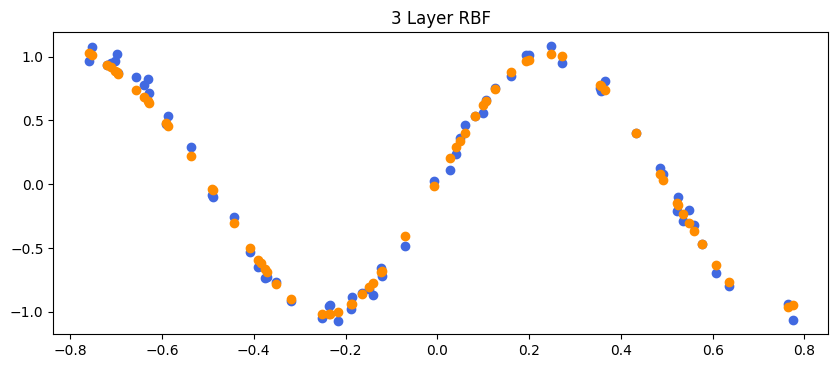

In [ ]:
plt.scatter(X_test, y_test, color='royalblue')
plt.scatter(X_test, yhat_eval, color='darkorange')
plt.title("3 Layer RBF")
plt.rcParams['figure.figsize'] = [10, 4] #set size of plot in output
plt.rcParams['figure.dpi'] = 150 # 200 e.g. is really fine, but slower
#plt.scatter(X_train, y_train, color='green')
#plt.legend(['Function f(x)', 'RBF output g(x)', 'Training set'])